In [1]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

from gensim.corpora import Dictionary
from gensim.sklearn_api.tfidf import TfIdfTransformer
from gensim.matutils import corpus2csc

import numpy as np
import matplotlib.pyplot as py
import matplotlib.animation as animation

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cats=['sci.space', 'comp.graphics']

In [3]:
newsgroups = fetch_20newsgroups(subset='train',
                                categories=['sci.space', 'comp.graphics'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, random_state=49)

id2word = Dictionary([_.split() for _ in X_train])

train_corpus = [id2word.doc2bow(i.split()) for i in X_train]
test_corpus = [id2word.doc2bow(i.split()) for i in X_test]

In [5]:
print (len(X_train), len(X_test))

(882, 295)


In [6]:
# We perform our analysis on top k documents which is almost top 10% most scored documents
k = len(X_test)/10

In [7]:
# Sort the document scores by their scores and return a sorted list 
# of document score and corresponding document lengths.
def sortLengthByScore(doc_scores, X_test):
    doc_scores = sorted(enumerate(doc_scores), key=lambda x: x[1])
    doc_leng=np.empty(len(doc_scores))
    ds=np.empty(len(doc_scores))
    for i,_ in enumerate(doc_scores):
        doc_leng[i]=len(X_test[_[0]])
        ds[i]=_[1]
    return ds, doc_leng

In [8]:
# This function returns the model accuracy and indivitual document prob values using
# gensim's TfIdfTransformer and sklearn's LogisticRegression
def getTfidfScores(kwargs):
    tfidf_transformer = TfIdfTransformer(**kwargs).fit(train_corpus)

    X_train_tfidf = corpus2csc(tfidf_transformer.transform(train_corpus), num_terms=len(id2word)).T
    X_test_tfidf = corpus2csc(tfidf_transformer.transform(test_corpus), num_terms=len(id2word)).T

    clf = LogisticRegression().fit(X_train_tfidf, y_train)

    model_accuracy = clf.score(X_test_tfidf, y_test)
    doc_scores = clf.decision_function(X_test_tfidf)
    
    return model_accuracy, doc_scores

### Get TFIDF scores for corpus without pivoted document length normalisation

In [9]:
params = {}
model_accuracy, doc_scores = getTfidfScores(params)
print (model_accuracy)

0.9661016949152542


In [10]:
print ("Normal cosine normalisation favors short documents as our top {} docs have a smaller mean doc length of {} compared to the corpus mean doc length of {}"
       .format(k,  sortLengthByScore(doc_scores, X_test)[1][:k].mean(), sortLengthByScore(doc_scores, X_test)[1].mean()))

Normal cosine normalisation favors short documents as our top 29 docs have a smaller mean doc length of 878.551724138 compared to the corpus mean doc length of 1686.73898305


### Get TFIDF scores for corpus with pivoted document length normalisation testing on various values of alpha.

In [11]:
best_model_accuracy = 0
optimum_slope = 0
for slope in np.arange(0,1.1, 0.1):
    params = {"pivot_norm":True, "slope":slope}

    model_accuracy, doc_scores = getTfidfScores(params)
    
    if model_accuracy>best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope
        
    print ("Score for slope {} is {}".format(slope, model_accuracy))
    
print ("We get best score of {} at slope {}".format(best_model_accuracy, optimum_slope))

Score for slope 0.0 is 0.95593220339
Score for slope 0.1 is 0.95593220339
Score for slope 0.2 is 0.959322033898
Score for slope 0.3 is 0.966101694915
Score for slope 0.4 is 0.969491525424
Score for slope 0.5 is 0.972881355932
Score for slope 0.6 is 0.972881355932
Score for slope 0.7 is 0.972881355932
Score for slope 0.8 is 0.972881355932
Score for slope 0.9 is 0.972881355932
Score for slope 1.0 is 0.966101694915
We get best score of 0.972881355932 at slope 0.5


In [12]:
params = {"pivot_norm":True, "slope":optimum_slope}
model_accuracy, doc_scores = getTfidfScores(params)
print (model_accuracy)

0.9728813559322034


In [13]:
print ("With pivoted normalisation top {} docs have mean length of {} which is much closer to the corpus mean doc length of {}"
       .format(k, sortLengthByScore(doc_scores, X_test)[1][:k].mean(), sortLengthByScore(doc_scores, X_test)[1].mean()))

With pivoted normalisation top 29 docs have mean length of 1399.86206897 which is much closer to the corpus mean doc length of 1686.73898305


## Visualizing the pivoted normalization

Score for slope 1.0 is 0.966101694915
Score for slope 0.9 is 0.972881355932
Score for slope 0.8 is 0.972881355932
Score for slope 0.7 is 0.972881355932
Score for slope 0.6 is 0.972881355932
Score for slope 0.5 is 0.972881355932
Score for slope 0.4 is 0.969491525424
Score for slope 0.3 is 0.966101694915
Score for slope 0.2 is 0.959322033898
Score for slope 0.1 is 0.95593220339
Score for slope 0.0 is 0.95593220339


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


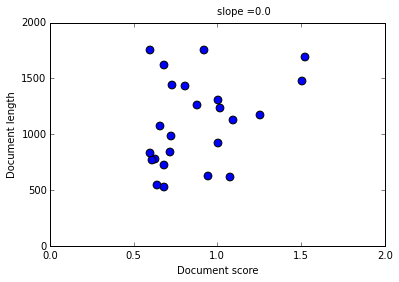

In [14]:
py.close('all') 

fig = py.figure(1)
ax = py.axes(xlim=(0,2), ylim=(0, 2000))

ax.set_xlabel('Document score')
ax.set_ylabel('Document length')

scat = ax.scatter([], [], s=60)
ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='center')

def init():
    scat.set_offsets([])
    return scat,ttl

def animate(i):
    slope = 1-i/10.0
    
    ttl.set_text("slope ="+str(slope))
    params = {"pivot_norm":True, "slope":slope}

    model_accuracy, doc_scores = getTfidfScores(params)

    print ("Score for slope {} is {}".format(slope, model_accuracy))
    doc_scores, doc_leng = sortLengthByScore(doc_scores, X_test)

    data = np.hstack((abs(doc_scores[:k,np.newaxis]), doc_leng[:k, np.newaxis]))
    scat.set_offsets(data)
    return scat,ttl

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=11, 
                               interval=1000, blit=False, repeat=False)

anim.save('line.gif', dpi=80, writer='imagemagick')

<img src="line.gif">

Since cosine normalization favors retrieval of short documents from the plot we can see that when slope was 1 (when pivoted normalisation was not applied) short documents with length of around 500 had very good score hence the bias for short documents can be seen. As we varied the value of slope from 1 to 0 we introdcued a new bias for long documents to counter the bias caused by cosine normalisation. Therefore at a certain point we got an optimum value of slope which is 0.5 where the overall accuracy of the model is increased.
